In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.datasets import MoleculeNet
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import pandas as pd
import ast

import copy
import glob
import json

from tqdm import tqdm

import ipywidgets as widgets
from torchinfo import summary
from pymatgen.core.periodic_table import Element
from collections import OrderedDict

import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper
from abc import ABC, abstractmethod

from src import botcher_hessian as hess
from src import botcher_utilities
#from src import utils

In [18]:
# Check if CUDA is available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" # GPU version generates some error for now. Fix it later. 
print(f"Using device: {device}")

Using device: cpu


### Load Data

In [11]:
variable = "esol_morgan"

clustered_data_file = "/home/substrate/projects/molmim_embedding_prediction/data/clustered_%s.csv"%variable
best_model_file = "/home/substrate/projects/molmim_embedding_prediction/data/models/best_model_%s.pth"%variable

df = pd.read_csv(clustered_data_file)
df

,Unnamed: 0,smiles,fingerprints,targets,clusters
0,0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.770,0
1,1,Cc1occc1C(=O)Nc2ccccc2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.300,0
2,2,CC(C)=CCCC(C)=CC(=O),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.060,0
3,3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-7.870,0
4,4,c1ccsc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.330,0
...,...,...,...,...,...
1123,1123,FC(F)(F)C(Cl)Br,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.710,0
1124,1124,CNC(=O)ON=C(SC)C(=O)N(C)C,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.106,0
1125,1125,CCSCCSP(=S)(OC)OC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.091,0
1126,1126,CCC(C)C,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.180,0


In [12]:
# Extract features and targets
temp_ID_X = [ast.literal_eval(a) for a in df[df['clusters']==0]['fingerprints']]
fingerprints = np.array([a for a in temp_ID_X])

targets = np.asarray(df[df['clusters']==0]['targets'], dtype=np.float32)

X_train, X_test_ID, y_train, y_test_ID  = train_test_split(fingerprints, targets, train_size=0.9, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42) 

In [47]:

# Create a PyTorch Dataset class
class ESOLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader instances
batch_size = 32
train_dataset = ESOLDataset(X_train, y_train)
validation_dataset = ESOLDataset(X_val, y_val)
test_dataset = ESOLDataset(X_test_ID, y_test_ID)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### OUT OF DISTRIBUTION #####
# Extract features and targets
temp_OOD_X = [ast.literal_eval(a) for a in df[df['clusters']==-1]['fingerprints']]
X_test_OOD = np.array([a for a in temp_OOD_X])

y_test_OOD = np.asarray(df[df['clusters']==-1]['targets'], dtype=np.float32)

test_OOD_dataset = ESOLDataset(X_test_OOD, y_test_OOD)

test_OOD_loader = DataLoader(test_OOD_dataset, batch_size=batch_size, shuffle=False)

### Load Model

In [14]:

# Define a PyTorch-based Gradient Boosting Model
class BoostingRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(BoostingRegressor, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_dim, 1))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


# Best parameters
best_params = {'dropout_rate': np.float64(0.1624074561769746),
                'hidden_dim': np.float64(93.9509479045509),
                'lr': np.float64(0.0006750277604651748),
                'num_layers': np.float64(4.598528437324806)}

# Load model
loaded_model = BoostingRegressor(input_dim=X_test_ID.shape[1], 
                                 hidden_dim=int(best_params['hidden_dim']), 
                                 num_layers=int(best_params['num_layers']), 
                                 dropout_rate=best_params['dropout_rate']).to(device)
loaded_model.load_state_dict(torch.load(best_model_file))
loaded_model.eval()
print("Model loaded successfully.")

Model loaded successfully.


In [15]:
summary(loaded_model)

Layer (type:depth-idx)                   Param #
BoostingRegressor                        --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       190,557
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       8,742
│    └─ReLU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       8,742
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      94
Total params: 208,135
Trainable params: 208,135
Non-trainable params: 0

### Getting the Hessian Eigenvectors

The following functions are copy-pasted from Botcher implementation. I put them here so that I could debug more easily.

In [16]:
### Defaults from OG implementation
loss_func = torch.nn.MSELoss()
func = copy.deepcopy(loaded_model)
og_params = [i[1] for i in func.named_parameters() if len(i[1].size()) > 1]
og_layer_names = [i[0] for i in func.named_parameters() if len(i[1].size())>1]

This next cell calculates the eigenvectors, and can take considerable time (upwards of 40 minutes)

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

maxeig, mineig, maxeigvec, mineigvec, num_iter = hess.min_max_hessian_eigs(
    func, X_train_tensor, y_train_tensor, loss_func, all_params=False
    )

207855


In [20]:
print(maxeig, mineig)

124.58057 -0.9345152928753464


### Formatting as two new models

In [21]:
max_model_wts = hess.npvec_to_tensorlist(maxeigvec, og_params)
min_model_wts = hess.npvec_to_tensorlist(mineigvec, og_params)

model_eig_max = copy.deepcopy(func)
model_eig_min = copy.deepcopy(func)

# There will be some incompatible keys due to the batch norm values
# the original batch norm values will be retained

model_wt_dict = OrderedDict([i for i in loaded_model.named_parameters()])

def force_wts_into_model(og_layer_names, new_model_wts, empty_model, old_model_state_dict):

    new_model_wt_dict = copy.deepcopy(old_model_state_dict)

    for layer, new_param in zip(og_layer_names, new_model_wts):
        if new_param.shape == old_model_state_dict[layer].shape:
            new_model_wt_dict[layer] = new_param
        else:
            print(layer+" incompatible")

    err_layers = empty_model.load_state_dict(new_model_wt_dict, strict=False)
    print(err_layers)

    return empty_model

model_eig_max = force_wts_into_model(og_layer_names, max_model_wts, model_eig_max,  model_wt_dict)
model_eig_min = force_wts_into_model(og_layer_names, min_model_wts, model_eig_min,  model_wt_dict)

<All keys matched successfully>
<All keys matched successfully>


In [22]:
torch.save(model_eig_max.state_dict(), 'data/models/model_eig_max.pt')
torch.save(model_eig_min.state_dict(), 'data/models/model_eig_min.pt')

## Create 2D Directed Loss Surface

In [23]:
import loss_landscapes
import loss_landscapes.metrics

from loss_landscapes.model_interface.model_wrapper import ModelWrapper
from abc import ABC, abstractmethod

In [24]:
DISTANCE = 0.3
STEPS = 40

In [25]:
# This is the custom model wrapper for the loss landscapes calculation
class Metric(ABC):
    """ A quantity that can be computed given a model or an agent. """

    def __init__(self):
        super().__init__()

    @abstractmethod
    def __call__(self, model_wrapper: ModelWrapper):
        pass

class Loss(Metric):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, loss_fn, model, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.model = model
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        outputs = model_wrapper.forward(self.inputs)
        err = self.loss_fn(self.target[0], outputs)
        return err

In [44]:
def calc_average_loss_array(data_loader):
    loss_landscapes_list = []
    for batch_X, batch_y in data_loader:
        metric = Loss(loss_func, func.eval(), batch_X, batch_y)
        try:
            loss_data_fin = loss_landscapes.planar_interpolation(
                model_start=func.eval(), 
                model_end_one=model_eig_max.eval(),
                model_end_two=model_eig_min.eval(),
                metric=metric, steps=STEPS, deepcopy_model=True
                )
            loss_landscapes_list.append(loss_data_fin)
        except Exception as e:
            print(e)
            # continue
            
    # Convert list to a NumPy array (3D array)
    stacked_arrays = np.stack(loss_landscapes_list)  # Shape: (num_arrays, rows, cols)

    # Compute the average across the first axis (axis=0)
    average_array = np.mean(stacked_arrays, axis=0)
    return average_array

average_array = calc_average_loss_array(data_loader=train_loader)

/home/substrate/.conda/envs/loss_landscapes_demo/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/substrate/.conda/envs/loss_landscapes_demo/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [41]:
def plot_loss_contours(average_array):
    fig, ax = plt.subplots(1, 1)
    plt.contourf(np.log10(average_array), levels=50, cmap='jet')
    ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
    ax.axis('square')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    plt.colorbar()
    plt.show()

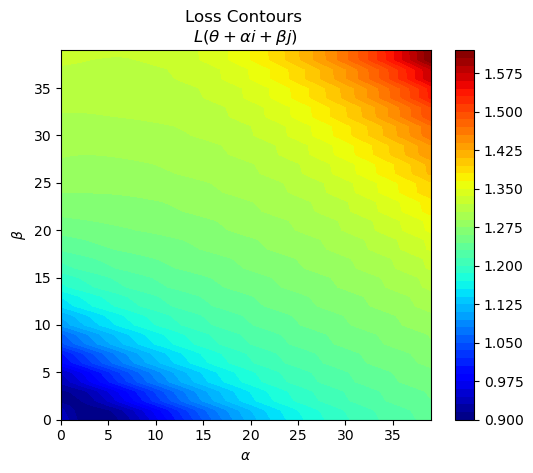

In [42]:
plot_loss_contours(average_array)

## Test data

In [45]:
average_array_test = calc_average_loss_array(data_loader=test_loader)

/home/substrate/.conda/envs/loss_landscapes_demo/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/substrate/.conda/envs/loss_landscapes_demo/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


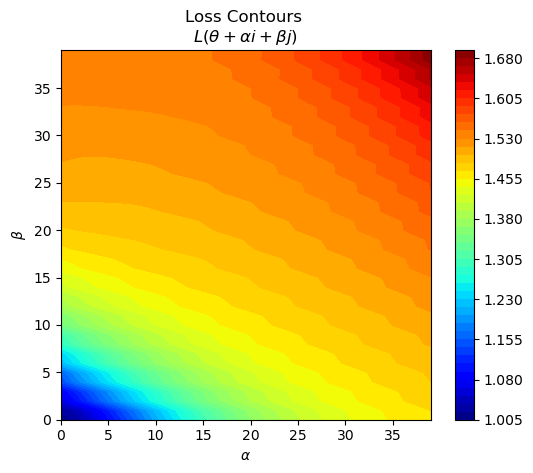

In [46]:
plot_loss_contours(average_array_test)

/home/substrate/.conda/envs/loss_landscapes_demo/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/substrate/.conda/envs/loss_landscapes_demo/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


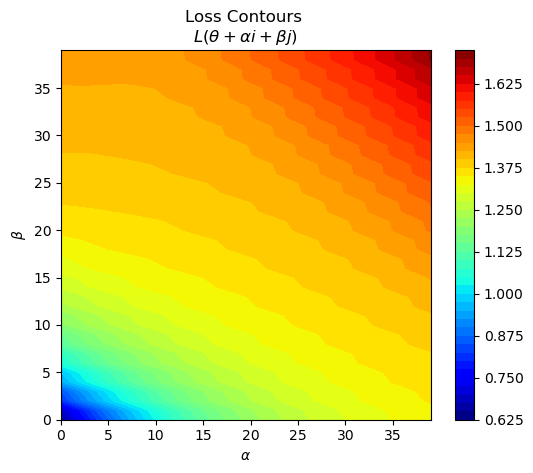

In [48]:
average_array_test_OOD = calc_average_loss_array(data_loader=test_OOD_loader)
plot_loss_contours(average_array_test_OOD)